### Fitting and predicting with returns

This notebook is my work interspersed with an orginal Darts notebook 

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import logging

import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from darts import concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, ElectricityDataset, MonthlyMilkDataset
from darts.metrics import mae, mape
from darts.models import (
    VARIMA,
    BlockRNNModel,
    NBEATSModel,
    RNNModel,
)
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries,
    sine_timeseries,
)

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

### Now to me

In [2]:
from darts import TimeSeries
from pathlib import Path
import pandas as pd
import pickle

### The "LazyFetch" concept to fit multiple data files where more than one is to big for memory

In [ ]:
# from collections.abc import Sequence

# class LazyFetch(Sequence):
#     def __init__(self, filenames, relative_path):
#         self._filenames = filenames
#         self._relative_path = Path(relative_path)

#     def __getitem__(self, index):
#         return self._load_file(self._filenames[index])
    
#     def __len__(self):
#         return len(self._filenames)
    
#     def _load_file(self, filename):
#         print(f"loading file {filename}")
#         if filename == "AirPassengers.csv":
#             file_path = self._relative_path / "AirPassengers.csv"
#             df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
#         elif filename == "monthly-milk.csv":
#             file_path = self._relative_path / "monthly-milk.csv"        
#             df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)

#         df = df.asfreq('MS')
#         series_raw = TimeSeries.from_dataframe(df) 
#         scaler = Scaler()
#         series_scaled = scaler.fit_transform(series_raw)       
#         return series_scaled
    
# lazy_fetch = LazyFetch(["AirPassengers.csv", "monthly-milk.csv"], "../datasets")
# series = lazy_fetch[1]
# series

# To use in model fitting.
# model_air_milk.fit(series=lazy_fetch)

# But, this will be very I/O intensive as random indices to the sequential dataset will cause 
# very big files to be loaded into TimeSeries objects multiple times during fit()

# my_model.fit(series=LazyFetch)
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# loading file AirPassengers.csv
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# …


#### Define some functions

In [ ]:
raw_data_path = Path("../datasets")
scaled_data_path = Path("../datasets/scaled")
scaler_path = Path("../datasets/scalers")

def load_data_file(filename, relative_path):
    file_path = relative_path / filename
    df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
    df = df.asfreq('MS')
    series = TimeSeries.from_dataframe(df)    
    return series

def save_series(series, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    series.to_csv(file_path)

def create_scaler(scaler, name):
    if scaler == "MinMaxScaler":
        return Scaler(scaler=MinMaxScaler(feature_range=(0, 1)), name=name)
    elif scaler == "StandardScaler":
        return Scaler(scaler=StandardScaler(), name=name)
    
def save_scaler(scaler, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(filename, relative_path):
    file_path = relative_path / filename
    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)
    return scaler    


#### Load raw data files, create and fit scalars & scale the TimeSeries

In [5]:
air_series_raw = load_data_file("AirPassengers.csv", raw_data_path)
air_scaler = create_scaler("MinMaxScaler", "air")
air_scaler = air_scaler.fit(air_series_raw)
air_series_scaled = air_scaler.transform(air_series_raw)

milk_series_raw = load_data_file("monthly-milk.csv", raw_data_path)
milk_scaler = create_scaler("MinMaxScaler", "milk")
milk_scaler = milk_scaler.fit(milk_series_raw)
milk_series_scaled = milk_scaler.transform(milk_series_raw)

#### Plot the raw series and plot the scaled series

Notice that the plots are identical to the Darts implementation in a cell lower down under Read Data and Preprocessing

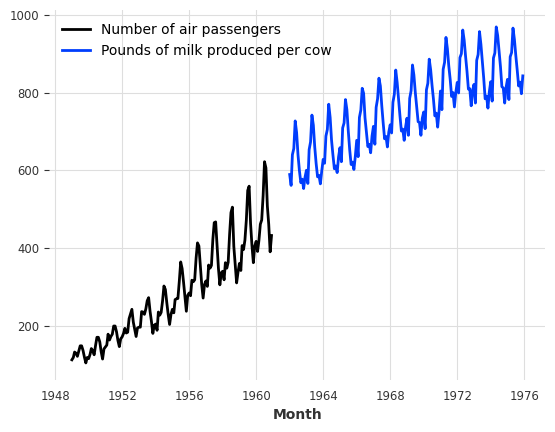

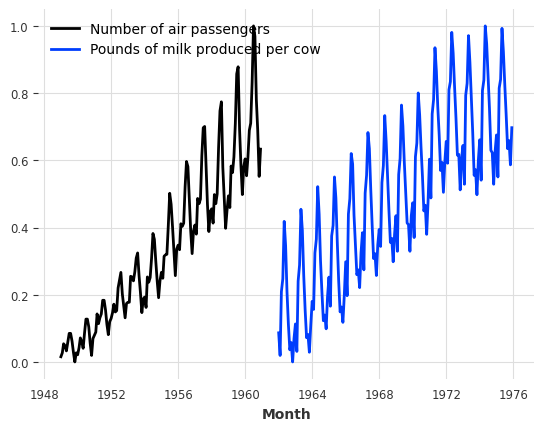

In [6]:
air_series_raw.plot(label="Number of air passengers")
milk_series_raw.plot(label="Pounds of milk produced per cow")
plt.legend();
plt.show()

air_series_scaled.plot(label="Number of air passengers")
milk_series_scaled.plot(label="Pounds of milk produced per cow")
plt.legend();
plt.show()

#### Save and load the scalars

In [7]:
save_scaler(air_scaler, "air.pkl", scaler_path)
save_scaler(milk_scaler, "milk.pkl", scaler_path)
del air_scaler
del milk_scaler
air_scaler = load_scaler("air.pkl", scaler_path)
milk_scaler = load_scaler("milk.pkl", scaler_path)
print(air_scaler)
print(milk_scaler)

air
milk


#### Save and load the scaled series

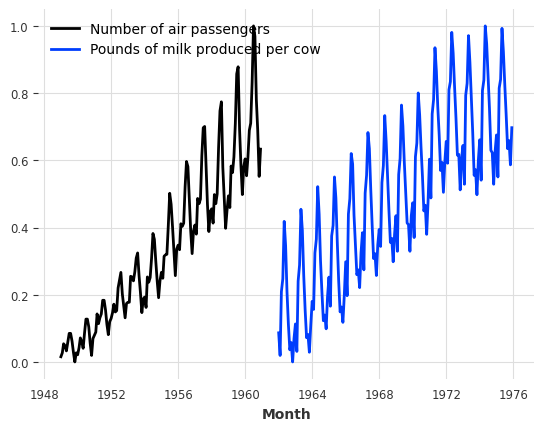

In [ ]:
save_series(air_series_scaled, "AirPassengers.csv", scaled_data_path)
save_series(milk_series_scaled, "monthly-milk.csv", scaled_data_path)
del air_series_scaled
del milk_series_scaled
air_series_scaled = load_data_file("AirPassengers.csv", scaled_data_path)
milk_series_scaled = load_data_file("monthly-milk.csv", scaled_data_path)

air_series_scaled.plot(label="Number of air passengers")
milk_series_scaled.plot(label="Pounds of milk produced per cow")
plt.legend();
plt.show()

### Test transformation from values to scaled returns and back to values

This is necessary to train market data on TFMs.  Using the StandardScalar.

Step 1: In a dataframe, convert values to returns (pct_change).  Also, save the first value

In [9]:
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from icecream import ic

# Define the custom business day with US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
index = pd.date_range(start="1/2/2018", periods=20, freq=us_bd)
index.name = "date"
display(index)

values = [
    21.49, 21.68, 22.33, 21.45, 21.56, 20.98, 21.18, 22.14, 22.25, 22.08,
    22.3, 21.94, 22.68, 22.71, 23.07, 22.54, 22.2, 22.41, 22.09, 22.25
]
df = pd.DataFrame(values, index=index, columns=["value"])
df["return"] = df["value"].pct_change()
# convert NaN to zero
df = df.fillna(0)
display(df)

# Save the first value
first_value = df.iloc[0]["value"]
# Print first_value using icecream
_ = ic(first_value)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30'],
              dtype='datetime64[ns]', name='date', freq='C')

,value,return
date,,
2018-01-02,21.49,0.000000
2018-01-03,21.68,0.008841
2018-01-04,22.33,0.029982
2018-01-05,21.45,-0.039409
2018-01-08,21.56,0.005128
2018-01-09,20.98,-0.026902
2018-01-10,21.18,0.009533
2018-01-11,22.14,0.045326
2018-01-12,22.25,0.004968


ic| first_value: 21.49


Step 2: Create a TimeSeries from the dataframe

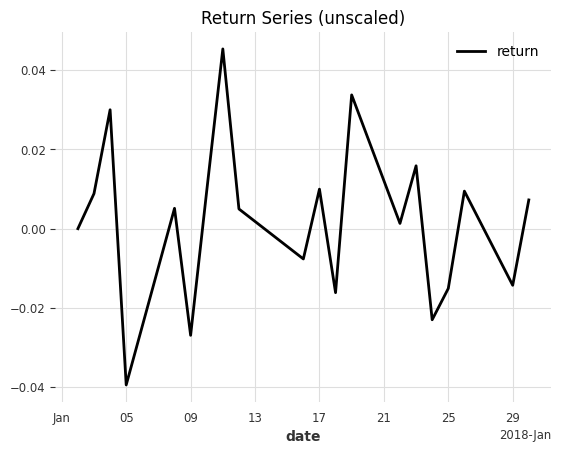

In [10]:
# convert column return to a time series
return_series_unscaled = TimeSeries.from_dataframe(df, value_cols=["return"])
return_series_unscaled.plot()
plt.title("Return Series (unscaled)")
plt.show()

Step 3: Create a scaler (StandardScaler) and fit the return series.  Also, transform the return series.

Note:
1. fit must be done on a sample that fully represents the distribution of returns in the universe.
2. The inverse transform recovers the unscaled returns.

Here's code to do 1.

In [11]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

# # Define the path to your large file
# file_path = 'path/to/your/large_file.csv'

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Define the chunk size
# chunk_size = 10000  # Adjust this based on your memory constraints

# # First pass: Fit the scaler on the data
# for chunk in pd.read_csv(file_path, chunksize=chunk_size):
#     scaler.partial_fit(chunk[['value', 'return']])

# # Second pass: Transform the data and save to a new file
# with pd.read_csv(file_path, chunksize=chunk_size) as reader:
#     for chunk in reader:
#         chunk[['value', 'return']] = scaler.transform(chunk[['value', 'return']])
#         chunk.to_csv('path/to/your/standardized_large_file.csv', mode='a', header=not bool(reader.line_num), index=False)

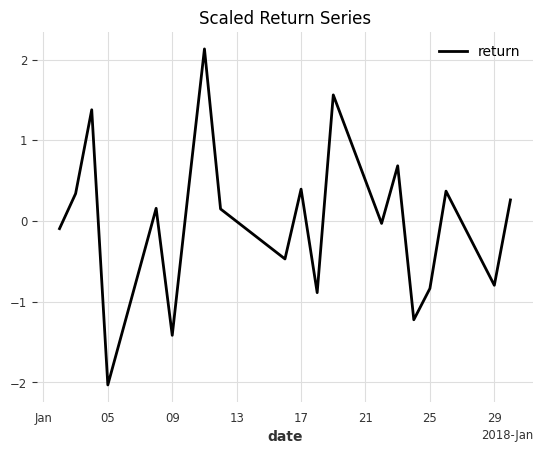

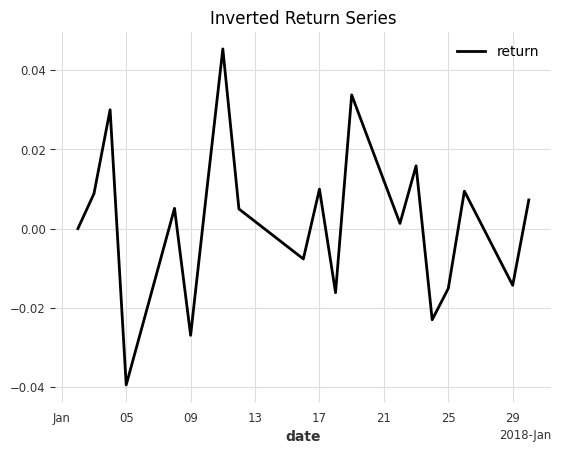

In [12]:
return_scaler = create_scaler("StandardScaler", "return")
return_scaler = return_scaler.fit(return_series_unscaled)
return_series_scaled = return_scaler.transform(return_series_unscaled)
return_series_scaled.plot()
plt.title("Scaled Return Series")
plt.show()

# Invert the scaling
return_series_inverted = return_scaler.inverse_transform(return_series_scaled)
return_series_inverted.plot()
plt.title("Inverted Return Series")
plt.show()

Step 4: After inverting the return series, convert to a dataframe and perform steps to recover the original values

In [13]:
df = return_series_inverted.pd_dataframe()
df.columns.name = None
df.loc[:, "1+return"] = df["return"].add(1)
df.loc[:, "cumprod"] = df["1+return"].cumprod()
df.loc[:, "value"] = df["cumprod"] * first_value
display(df)

,return,1+return,cumprod,value
date,,,,
2018-01-02,0.000000,1.000000,1.000000,21.49
2018-01-03,0.008841,1.008841,1.008841,21.68
2018-01-04,0.029982,1.029982,1.039088,22.33
2018-01-05,-0.039409,0.960591,0.998139,21.45
2018-01-08,0.005128,1.005128,1.003257,21.56
2018-01-09,-0.026902,0.973098,0.976268,20.98
2018-01-10,0.009533,1.009533,0.985575,21.18
2018-01-11,0.045326,1.045326,1.030247,22.14
2018-01-12,0.004968,1.004968,1.035365,22.25


### Back to Darts

### Read Data
Let's start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow. These time series have not much to do with each other, except that they both have a monthly frequency with a marked yearly periodicity and upward trend, and (completely coincidentaly) they contain values of a comparable order of magnitude.

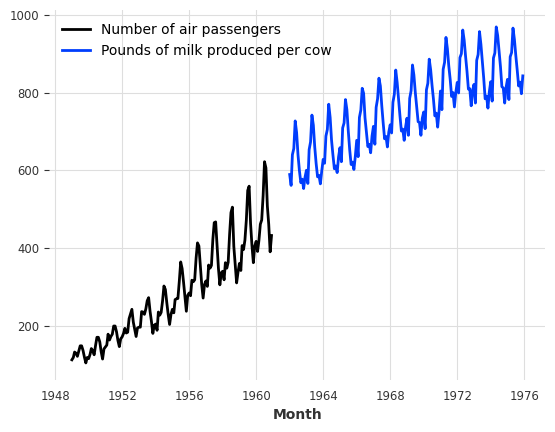

In [14]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

### Preprocessing
Usually neural networks tend to work better on normalised/standardised data. Here we'll use the `Scaler` class to normalise both of our time series between 0 and 1:

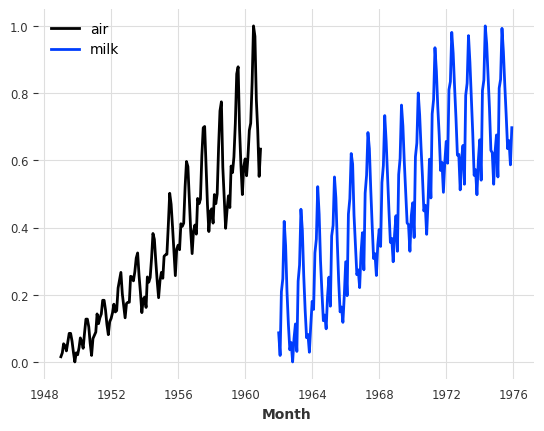

In [15]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

### Train / Validation split
Let's keep the last 36 months of both series as validation:

In [16]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

## Global Forecasting Models
Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called *global* models. An exhaustive list of the global models can be found [here](https://unit8co.github.io/darts/README.html#forecasting-models) (bottom of the table) with for example:

* LinearRegressionModel
* BlockRNNModel
* Temporal Convolutional Networks (TCNModel)
* N-Beats (NBEATSModel)
* TiDEModel

In the following, we will distinguish two sorts of time series:

* The **target time series** is the time series we are interested to forecast (given its history)
* A **covariate time series** is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It's sometimes also called *external data*.

**Note**: Static covariates are invariant in time and correspond to additional information associated with the components of the **target time series**. Detailed information about this kind of covariate can be found in the [static covariates notebook](https://unit8co.github.io/darts/examples/15-static-covariates.html).

We further differentiate covariates series, depending on whether they can be known in advance or not:

* **Past Covariates** denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed.
* **Future Covariates** denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts. 

Some models use only past covariates, others use only future covariates, and some models might use both. We will dive deeper in this topic in some other notebook, but this [table](https://unit8co.github.io/darts/README.html#forecasting-models) details the covariates supported by each model.

All of the global models listed above support training on multiple series. In addition, they also all support *multivariate series*. This means that they can seamlessly be used with time series of more than one dimension; the target series can contain one (as is often the case) or several dimensions. A time series with several dimensions is really just a regular time series where the values at each time stamps are vectors instead of scalars.

As an example, the BlockRNNModel, N-Beats, TCN and Transformer models follow a "block" architecture. They contain a neural network that takes chunks of time series in input, and outputs chunks of (predicted) future time series values. The input dimensionality is the number of dimensions (components) of the target series, plus the number of components of all the covariates - stacked together. The output dimensionality is simply the number of dimensions of the target series:
![](static/images/global_io_covs.png)

The `RNNModel` works differently, in a recurrent fashion (which is also why they support future covariates).
The good news is that as a user, we don't have to worry too much about the different model types and input/output dimensionalities. The dimensionalities are automatically inferred for us by the model based on the training data, and the support for past or future covariates is simply handled by the `past_covariates` or `future_covariates` arguments. 

We'll still have to specify two important parameters when building our models:

* `input_chunk_length`: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous `input_chunk_length` points.
* `output_chunk_length`: this is the length of the outputs (forecasts) produced by the internal model. However, the `predict()` method of the "outer" Darts model (e.g., the one of `NBEATSModel`, `TCNModel`, etc) can be called for a longer time horizon. In these cases, if `predict()` is called for a horizon longer than `output_chunk_length`, the internal model will simply be called repeatedly, feeding on its own previous outputs in an auto-regressive fashion. If `past_covariates` are used it requires these covariates to be known for long enough in advance.

### Example with one Series
Let's look at a first example. We'll build an N-BEATS model that has a lookback window of 24 points (`input_chunk_length=24`) and predicts the next 12 points (`output_chunk_length=12`). We chose these values so it'll make our model produce successive predictions for one year at a time, looking at the past two years.

In [17]:
model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=200,
    random_state=0,
    **generate_torch_kwargs(),
)

This model can be used like any other Darts forecasting model, beeing fit on a single time series:

In [18]:
model_air.fit(train_air)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7faed9a5f310>]})

And like any other Darts forecasting models, we can then get a forecast by calling `predict()`. Note that below, we are calling `predict()` with a horizon of 36, which is longer than the model internal `output_chunk_length` of 12. That's not a problem here - as explained above, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

MAPE = 8.02%


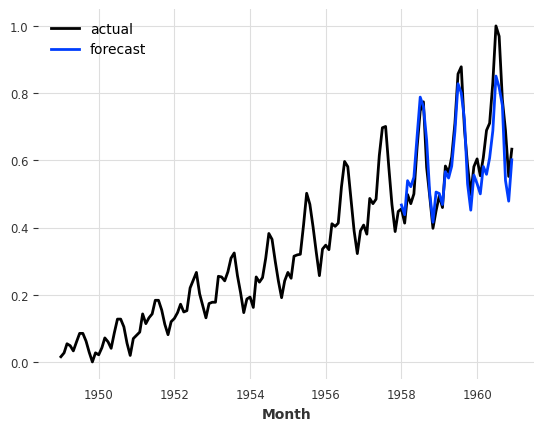

In [19]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(series_air_scaled, pred):.2f}%")

### Now to me

Let's duplicate the fitting and prediction, but with returns in place of the target component

First, without converting the target to returns

In [20]:
series_air = AirPassengersDataset().load()
scaler = create_scaler("MinMaxScaler", "air")
scaler = scaler.fit(series_air)
series_air_scaled = scaler.transform(series_air)
train_air_scaled, val_air_scaled = series_air_scaled[:-36], series_air_scaled[-36:]

model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=200,
    random_state=0,
    **generate_torch_kwargs(),
)

model_air.fit(train_air_scaled)
pred = model_air.predict(n=36)

Training: 0it [00:00, ?it/s]

MAPE = 8.02%


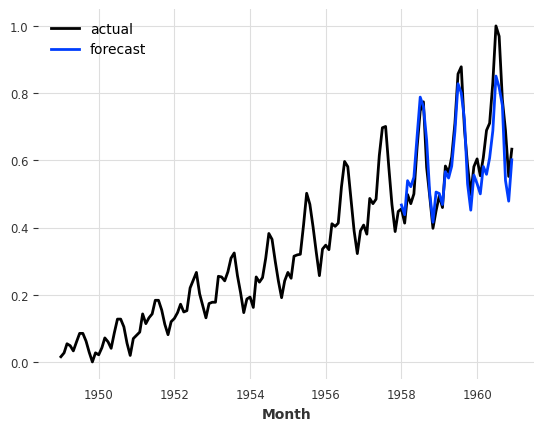

In [21]:
series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(series_air_scaled, pred):.2f}%")

MAPE = 6.08%


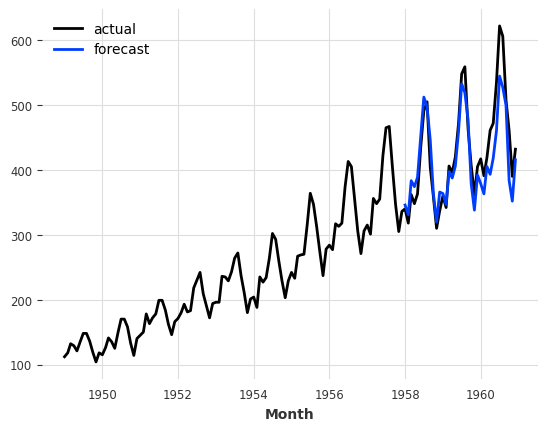

In [22]:
pred_unscaled = scaler.inverse_transform(pred)

series_air.plot(label="actual")
pred_unscaled.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(series_air, pred_unscaled):.2f}%")

Now, Repeat above converting the target to returns and then scaling

In [23]:
def returns_transform(series):
    df = series.pd_dataframe()
    target_col_name = df.columns[0]
    return_col_name = "return"
    df[return_col_name] = df[target_col_name].pct_change()
    # drop the first element as it will be NaN
    return TimeSeries.from_dataframe(df, value_cols=["return"])[1:]

In [24]:
series_air = AirPassengersDataset().load()
series_air_returns = returns_transform(series_air)

series_air_returns = series_air_returns

scaler = create_scaler("MinMaxScaler", "air")
scaler = scaler.fit(series_air_returns)
series_air_returns_scaled = scaler.transform(series_air_returns)

train_air, val_air = series_air_returns_scaled[:-36], series_air_returns_scaled[-36:]

In [25]:
model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=200,
    random_state=0,
    **generate_torch_kwargs(),
)

In [26]:
model_air.fit(train_air)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7faed9aacdf0>]})

In [27]:
pred_returns_scaled = model_air.predict(n=36)

In [28]:
def returns_inverse_transform(pred_return_series, hist_series):
    end_time = hist_series.end_time()
    top_row = pd.DataFrame({"return": [0]}, index=[end_time])

    df = pred_return_series.pd_dataframe()
    df = pd.concat([top_row, df])

    last_value = hist_series.last_value()
    target_col_name = hist_series.components[0]
    df[target_col_name] = df["return"].add(1).cumprod().mul(last_value)

    return TimeSeries.from_dataframe(df[1:], value_cols=[target_col_name])

MAPE = 6.30%


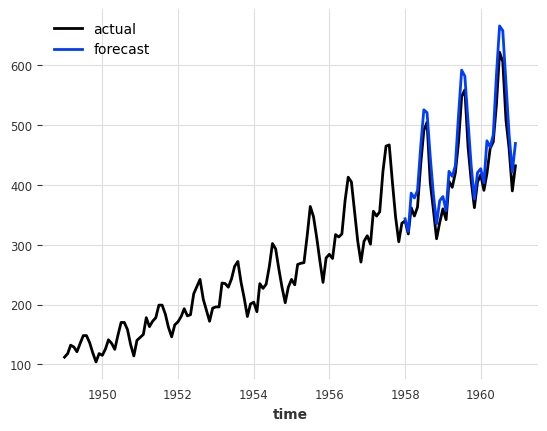

In [29]:
pred_returns_unscaled = scaler.inverse_transform(pred_returns_scaled)

hist_series = series_air[:-36]
pred = returns_inverse_transform(pred_returns_unscaled, hist_series)

series_air.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(series_air, pred):.2f}%")
